In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt

import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting  import register_matplotlib_converters

import statsmodels.api as sm
from statsmodels.tsa.api import Holt

from acquire import *

from env import user,host,password

In [2]:
def time_split(df, train_size = .5, validate_size = .3):
    '''Splits time series data based on percentages and returns train, validate, test THE
    DATAFRAME MUST BE CHRONOLOGICALLY SORTED!'''
    t_size = int(len(df) * train_size)
    v_size = int(len(df) * validate_size)
    end = t_size + v_size
    return df[0:t_size], df[t_size:end], df[end:len(df)+1]

In [3]:
df = pd.read_csv('saas.csv')
df.head()

,Month_Invoiced,Customer_Id,Invoice_Id,Subscription_Type,Amount
0,2014-01-31,1000000,5000000,0.0,0.0
1,2014-01-31,1000001,5000001,2.0,10.0
2,2014-01-31,1000002,5000002,0.0,0.0
3,2014-01-31,1000003,5000003,0.0,0.0
4,2014-01-31,1000004,5000004,1.0,5.0


In [4]:
# Fix column names
new_names = {col: col.lower() for col in df.columns}
df.rename(columns=new_names, inplace=True)
df.head()

,month_invoiced,customer_id,invoice_id,subscription_type,amount
0,2014-01-31,1000000,5000000,0.0,0.0
1,2014-01-31,1000001,5000001,2.0,10.0
2,2014-01-31,1000002,5000002,0.0,0.0
3,2014-01-31,1000003,5000003,0.0,0.0
4,2014-01-31,1000004,5000004,1.0,5.0


In [5]:
# Convert month_invoiced to datetime object to sort properly
df.month_invoiced = pd.to_datetime(df.month_invoiced)

In [6]:
# Date range is between Jan 31st 2014 and Dec 31st 2017
print('min date', df.month_invoiced.min(), '\n', 'max date:', df.month_invoiced.max())

## Examine features
# Seems that subscription type is categorical with 5 different types (0 - 4)
print('Sub Types', df.subscription_type.value_counts())

# It appears that the amount is associated with the sub type (0, 5 ,10, 15, 20)
print('Amount counts', df.amount.value_counts())

# There are duplicate customer_id observations for certain id's aggregating based on those
# might be a good start point
df.customer_id.value_counts()

min date 2014-01-31 00:00:00 
 max date: 2017-12-31 00:00:00
Sub Types 0.0    496410
1.0    178212
2.0     70706
3.0     26474
4.0     18656
Name: subscription_type, dtype: int64
Amount counts 0.0     496410
5.0     178212
10.0     70706
15.0     26474
20.0     18656
Name: amount, dtype: int64


1001961    48
1014093    48
1012840    48
1000265    48
1008461    48
           ..
1026527     1
1029387     1
1002772     1
1029257     1
1017545     1
Name: customer_id, Length: 29400, dtype: int64

In [7]:
df.head()

,month_invoiced,customer_id,invoice_id,subscription_type,amount
0,2014-01-31,1000000,5000000,0.0,0.0
1,2014-01-31,1000001,5000001,2.0,10.0
2,2014-01-31,1000002,5000002,0.0,0.0
3,2014-01-31,1000003,5000003,0.0,0.0
4,2014-01-31,1000004,5000004,1.0,5.0


In [8]:
# Groupby month_invoiced and sum the amount
gdf = pd.DataFrame(df.groupby('month_invoiced').amount.agg('sum'))
# sort index chronologically to prepare to split data and then rename column
gdf = gdf.sort_index().rename(columns={'amount': 'monthly_total'})
gdf.head()

,monthly_total
month_invoiced,
2014-01-31,35850.0
2014-02-28,37190.0
2014-03-31,38295.0
2014-04-30,39255.0
2014-05-31,40355.0


In [9]:
# Split the data into train, validate and test (50%, 30%, 20%)
train, validate, test = time_split(gdf)
# check the length of each splice of data
train.shape, validate.shape, test.shape

((24, 1), (14, 1), (10, 1))

In [10]:
def plot_samples(target_var):
    '''
   plot each attribute 
   '''
    plt.figure(figsize = (12,4))
    sns.lineplot(data=train[target_var], label='train')
    sns.lineplot(data=validate[target_var], label='validate')
    sns.lineplot(data=test[target_var], label='test')
    plt.title(target_var.title())
    plt.legend()

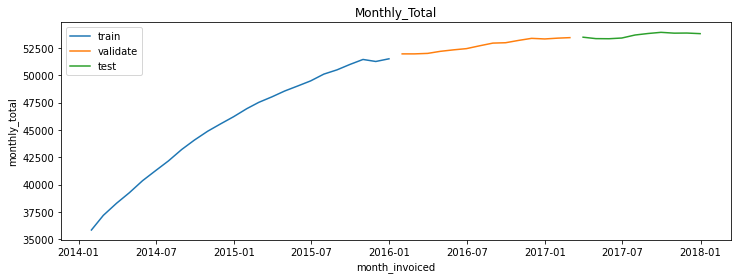

In [11]:
for col in train.columns:
    plot_samples(col)
    plt.show()

In [12]:
def evaluate(target_var):
    '''
    the evaluate function will take in the actual values and the predicted values
    and compute the mean_squared_error and then take the sqrt returning a rounded rmse
    '''
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])),0)
    return rmse

def plot_and_eval(target_var):
    '''
    a function to evaluate forecasts by computing the rmse and plot train and validate along with predictions
    '''
    plot_samples(target_var)
    sns.lineplot(data=yhat_df[target_var], label='RMSE')
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, f'--RMSE: {rmse:.0f}')
    plt.show()

In [13]:
# Create the empty dataframe with model_type, target_var, rmse
eval_df = pd.DataFrame(columns = ['model_type', 'target_var', 'rmse'])

def append_eval_df(model_type, target_var):
    '''
    this function will take in the model type as a string, target variable
    as a string, and run the evaluate function to compute rmse, 
    and append to the dataframe a row with the model type, 
    target variable and rmse. 
    '''
    rmse = evaluate(target_var)
    d= {'model_type':[model_type], 'target_var':[target_var], 'rmse':[rmse]}
    d= pd.DataFrame(d)
    return eval_df.append(d, ignore_index= True)

<center><h2> Forecast </h2></center>

### Last Observed Value
> - Utilize the last observed value to predict all future values as a form of a baseline

In [14]:
monthly_total = train.monthly_total[-1]
yhat_df = pd.DataFrame({'monthly_total': [monthly_total]},
                       index=validate.index)
yhat_df.head()

,monthly_total
month_invoiced,
2016-01-31,51505.0
2016-02-29,51505.0
2016-03-31,51505.0
2016-04-30,51505.0
2016-05-31,51505.0


monthly_total --RMSE: 1343


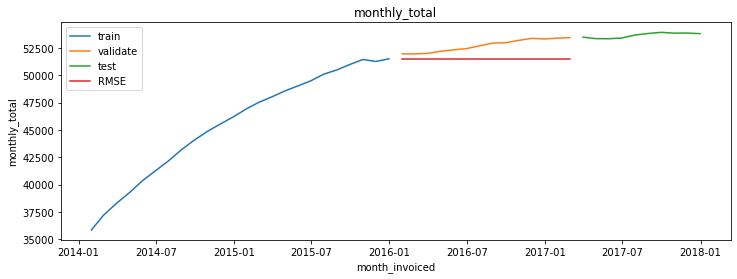

In [15]:
for column in train.columns:
    plot_and_eval(column)

In [16]:
for column in train.columns:
    eval_df = append_eval_df(model_type='last_observed_value',
                            target_var= column)
eval_df.head()

,model_type,target_var,rmse
0,last_observed_value,monthly_total,1343.0


### Simple Average

> - Utilize historical value averages to make predictions about the future values.

In [17]:
monthly_total = round(train.monthly_total.mean(), 0)
yhat_df = pd.DataFrame({'monthly_total': [monthly_total]},
                       index=validate.index)
yhat_df.head()

,monthly_total
month_invoiced,
2016-01-31,45569.0
2016-02-29,45569.0
2016-03-31,45569.0
2016-04-30,45569.0
2016-05-31,45569.0


monthly_total --RMSE: 7180


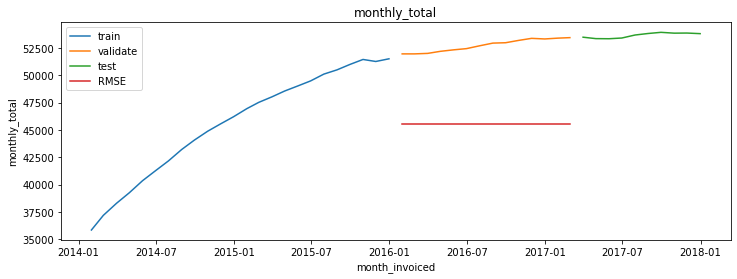

,model_type,target_var,rmse
0,last_observed_value,monthly_total,1343.0
1,simple_average,monthly_total,7180.0


In [18]:
for columns in train.columns:
    plot_and_eval(column)
    
for column in train.columns:
    eval_df = append_eval_df(model_type = 'simple_average',
                             target_var = column)
eval_df.head()

### Moving/Rolling Average
> - We will using a rolling monthly average (which will be tested for increasing period) up to a year.

monthly_total --RMSE: 1343


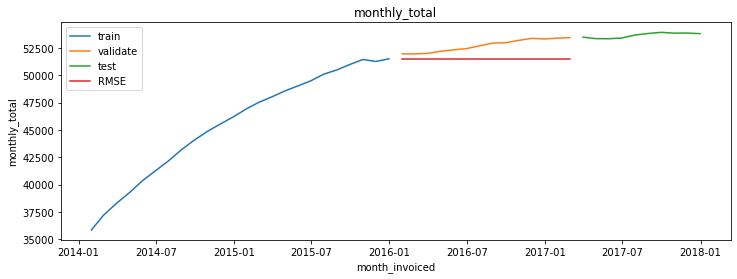

monthly_total --RMSE: 1455


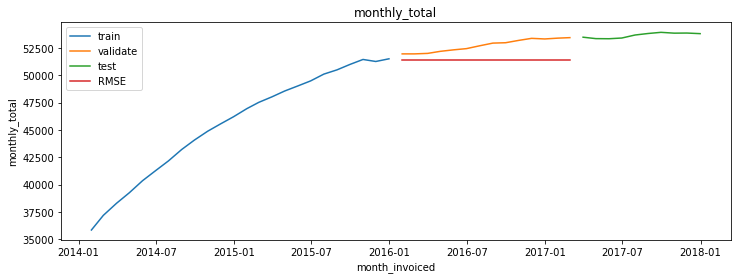

monthly_total --RMSE: 1436


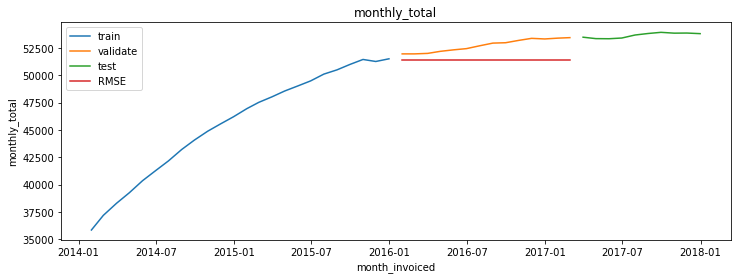

monthly_total --RMSE: 1533


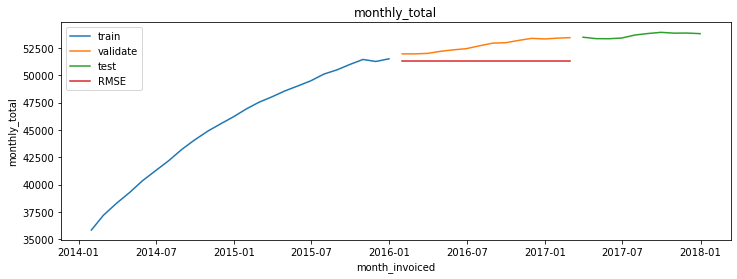

monthly_total --RMSE: 1684


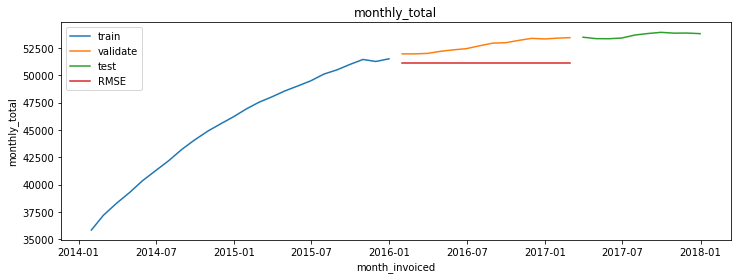

monthly_total --RMSE: 1847


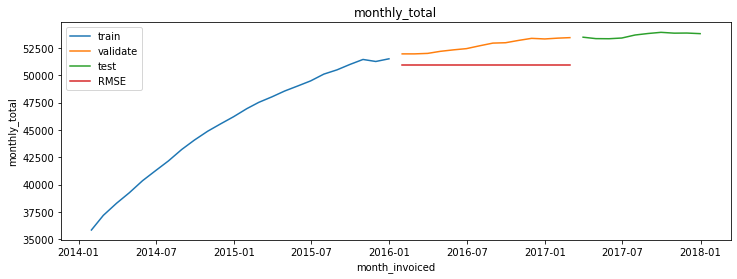

monthly_total --RMSE: 2050


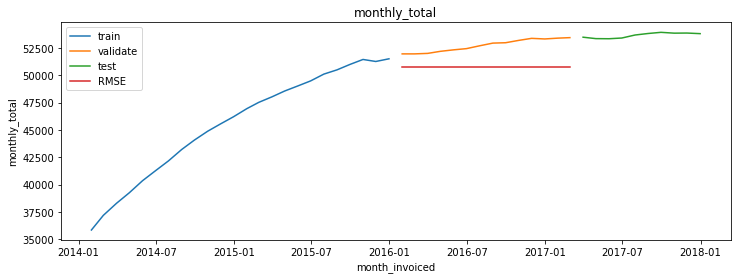

monthly_total --RMSE: 2259


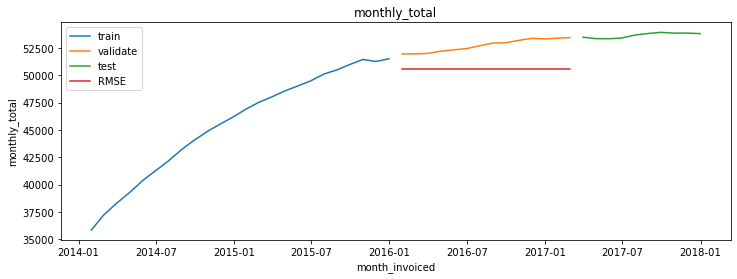

monthly_total --RMSE: 2472


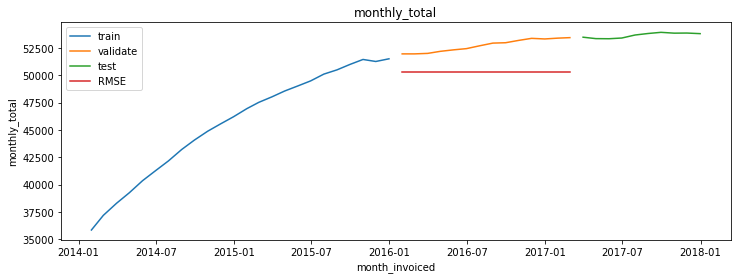

monthly_total --RMSE: 2696


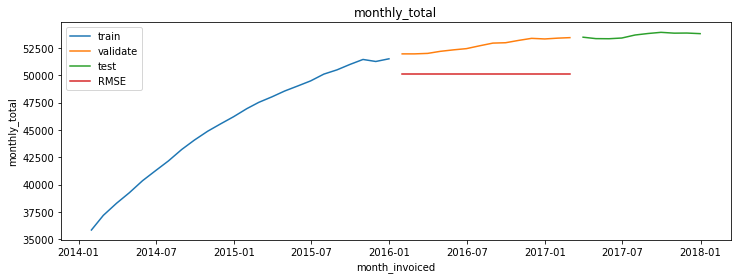

monthly_total --RMSE: 2925


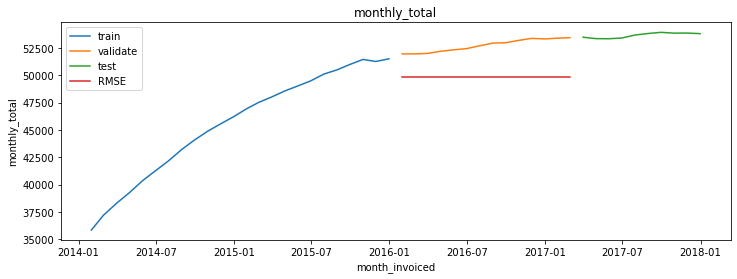

monthly_total --RMSE: 3164


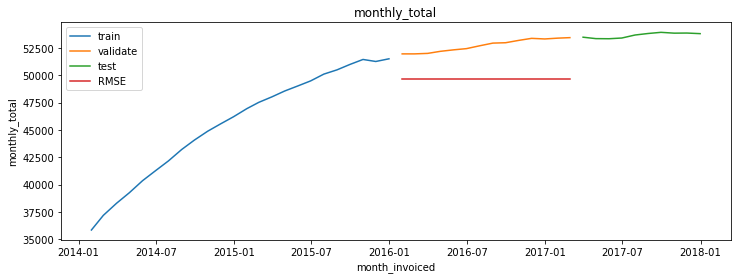

,model_type,target_var,rmse
0,last_observed_value,monthly_total,1343.0
1,simple_average,monthly_total,7180.0
2,moving_average_1_months,monthly_total,1343.0
3,moving_average_2_months,monthly_total,1455.0
4,moving_average_3_months,monthly_total,1436.0
5,moving_average_4_months,monthly_total,1533.0
6,moving_average_5_months,monthly_total,1684.0
7,moving_average_6_months,monthly_total,1847.0
8,moving_average_7_months,monthly_total,2050.0
9,moving_average_8_months,monthly_total,2259.0


In [19]:
for period in np.arange(1, 13):
    monthly_total = train.monthly_total.rolling(period).mean().iloc[-1]
    yhat_df = pd.DataFrame({'monthly_total': [monthly_total]},
                       index=validate.index)
    for column in train.columns:
        plot_and_eval(column)
    for column in train.columns:
        eval_df = append_eval_df(model_type = f'moving_average_{period}_months',
                             target_var = column)
eval_df

### Holt's Linear Trend

monthly_total


<Figure size 864x288 with 0 Axes>

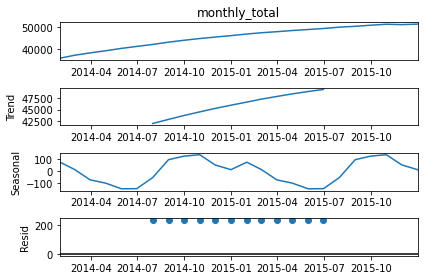

In [20]:
for column in train.columns:
    print(column, end='\n')
    plt.figure(figsize = (12,4))
    _ = sm.tsa.seasonal_decompose(train[column].resample('M').mean()).plot()
    plt.show()

/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


monthly_total --RMSE: 99


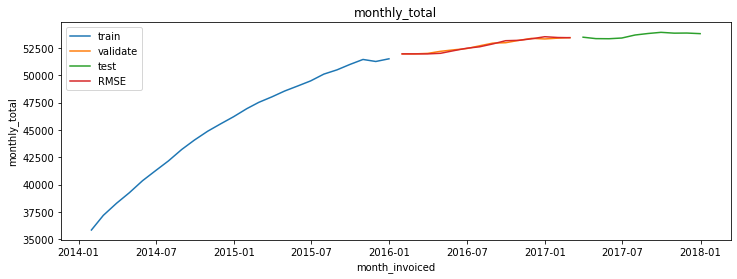

In [21]:
for column in train.columns:
    # Make model
    model = Holt(validate[column], exponential=False)
    # Fit model
    model = model.fit(smoothing_level=.6,
                     smoothing_slope=.95,
                     optimized=False)
    yhat = model.predict(start=validate.index[0],
                        end=validate.index[-1])
    yhat_df[column] = round(yhat, 2)

for column in train.columns:
    plot_and_eval(column)

In [22]:
for column in train.columns:
    eval_df = append_eval_df(model_type='Holts',
                            target_var=column)
eval_df

,model_type,target_var,rmse
0,last_observed_value,monthly_total,1343.0
1,simple_average,monthly_total,7180.0
2,moving_average_1_months,monthly_total,1343.0
3,moving_average_2_months,monthly_total,1455.0
4,moving_average_3_months,monthly_total,1436.0
5,moving_average_4_months,monthly_total,1533.0
6,moving_average_5_months,monthly_total,1684.0
7,moving_average_6_months,monthly_total,1847.0
8,moving_average_7_months,monthly_total,2050.0
9,moving_average_8_months,monthly_total,2259.0


### Previous Cycle
> - Total date range: 2014-1-31 to 2017-12-31
> - Utilize a previous cycle which will be monthly or every 30 days

monthly_total --RMSE: 108


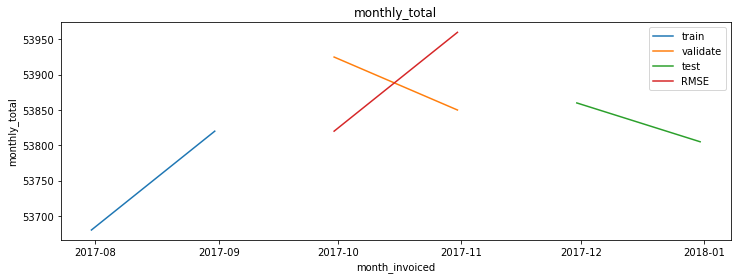

monthly_total --RMSE: 424


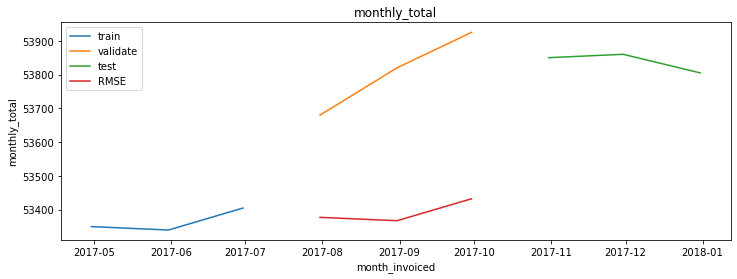

monthly_total --RMSE: 266


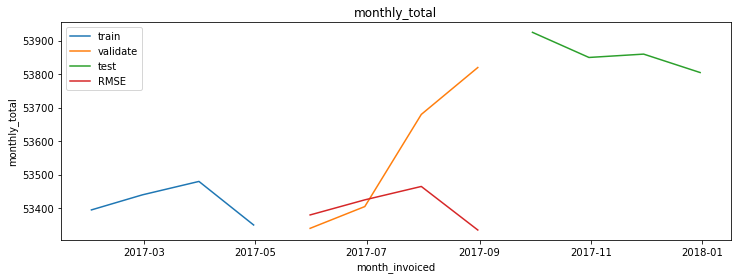

monthly_total --RMSE: 138


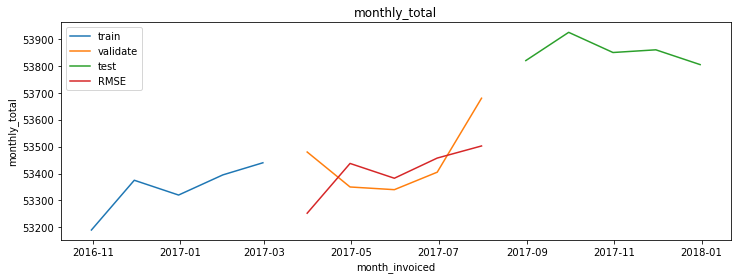

monthly_total --RMSE: 328


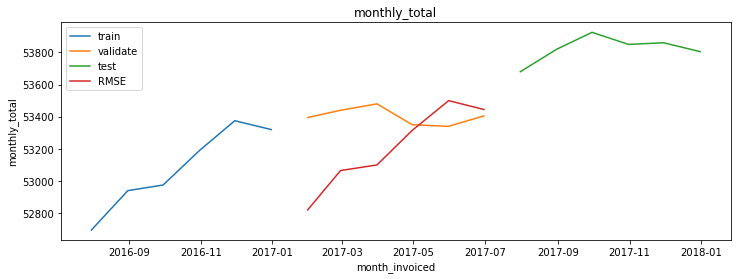

monthly_total --RMSE: 640


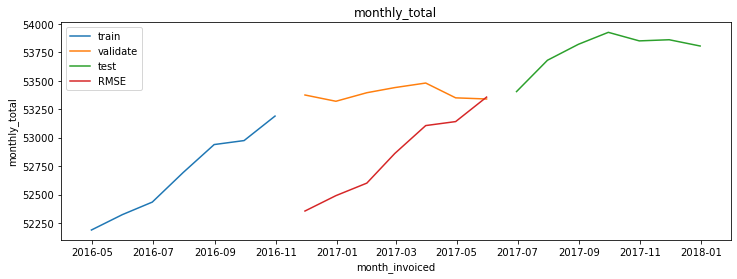

monthly_total --RMSE: 906


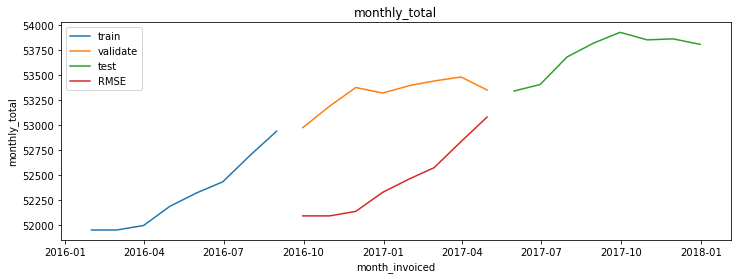

monthly_total --RMSE: 1195


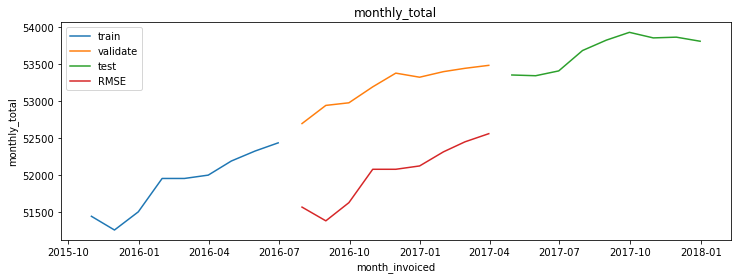

monthly_total --RMSE: 1416


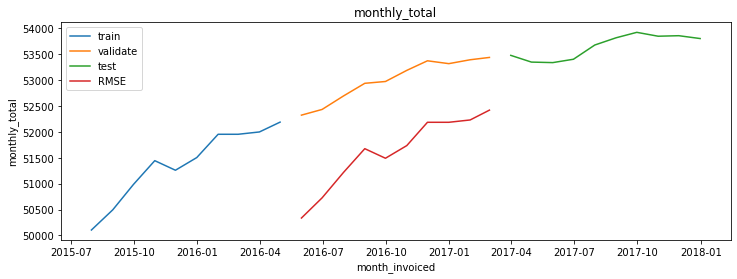

monthly_total --RMSE: 1964


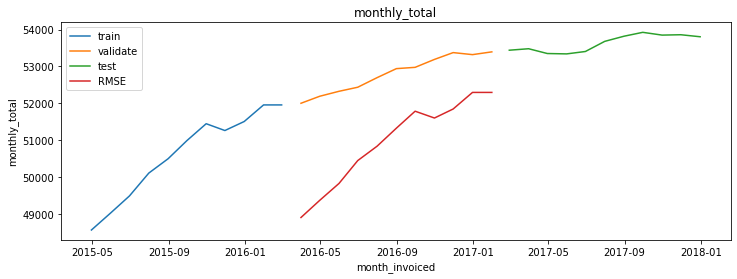

monthly_total --RMSE: 2784


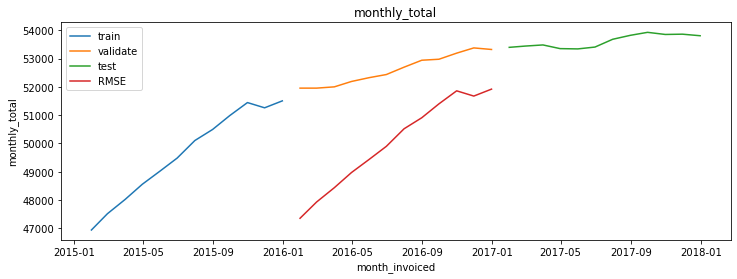

monthly_total --RMSE: 3701


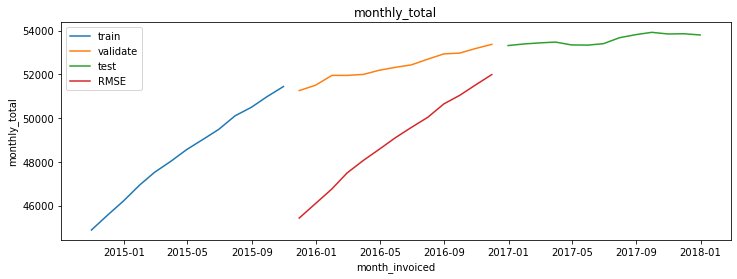

monthly_total --RMSE: 4988


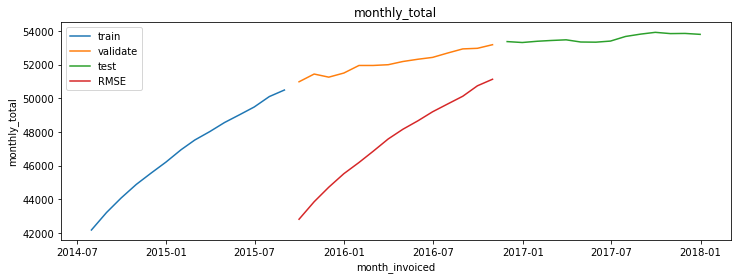

monthly_total --RMSE: 6436


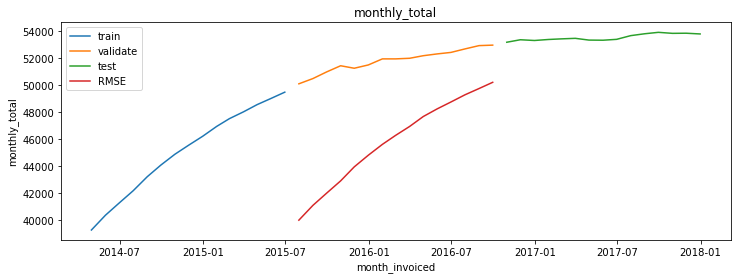

monthly_total --RMSE: 8015


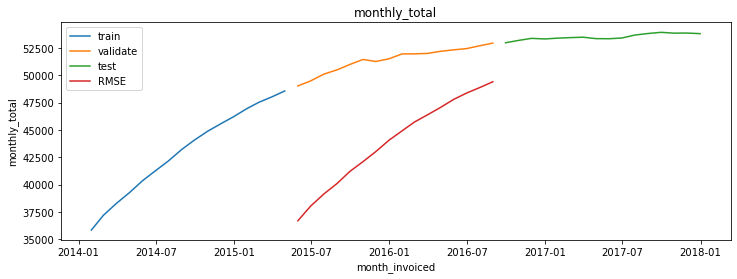

In [23]:
for n in range(2, 17):
    train = gdf.iloc[(n*3 * -1):(n*2*-1)]
    validate = gdf.iloc[(n*2*-1):(n*-1)]
    test = gdf.iloc[(n*-1):]

    yhat_df = train + train.diff().mean()

    pd.concat([yhat_df.head(1), validate.head(1)])
    yhat_df.index = validate.index

    for col in train.columns:
        plot_and_eval(col)
        eval_df = append_eval_df(model_type=f'previous{n}_months',
                                target_var=col)


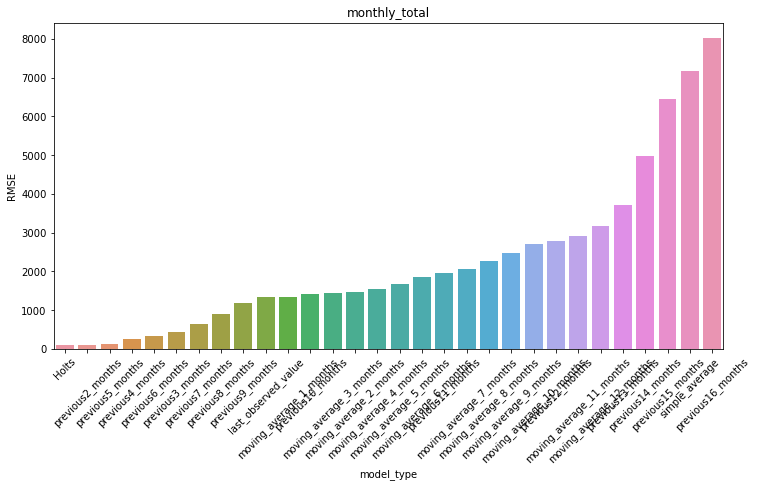

In [24]:
eval_df = eval_df.sort_values(by='rmse')
for col in train.columns:
    x = eval_df[eval_df.target_var == col]['model_type']
    y = eval_df[eval_df.target_var == col]['rmse']
    plt.figure(figsize=(12, 6))
    sns.barplot(x, y)
    plt.title(col)
    plt.ylabel('RMSE')
    plt.xticks(rotation=45)
    plt.show()

In [25]:
eval_df

,model_type,target_var,rmse
14,Holts,monthly_total,99.0
15,previous2_months,monthly_total,108.0
18,previous5_months,monthly_total,138.0
17,previous4_months,monthly_total,266.0
19,previous6_months,monthly_total,328.0
16,previous3_months,monthly_total,424.0
20,previous7_months,monthly_total,640.0
21,previous8_months,monthly_total,906.0
22,previous9_months,monthly_total,1195.0
0,last_observed_value,monthly_total,1343.0
